Step 1. Label images (done in labelImg programe).

Step 2. Change Runtime to GPU.

Step 3. Load google drive.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.environ['PATH'] += ':/usr/local/cuda/bin'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Step 4. Install darknet package.

In [0]:
!git clone https://github.com/AlexeyAB/darknet/
%cd /content/darknet
with open('Makefile') as f:
  makefile = f.read()
replace = [('GPU=0', 'GPU=1'),
           ('CUDNN=0', 'CUDNN=1'),
           ('OPENCV=0', 'OPENCV=1')]
for c1,c2 in replace:
  makefile = makefile.replace(c1, c2)
with open('Makefile', 'w') as f:
  f.write(makefile)
!make

Cloning into 'darknet'...
remote: Enumerating objects: 13229, done.
remote: Total 13229 (delta 0), reused 0 (delta 0), pack-reused 13229
Receiving objects: 100% (13229/13229), 11.92 MiB | 11.40 MiB/s, done.
Resolving deltas: 100% (9047/9047), done.
/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:910:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_

Step 5. Add images, labels, class names and directory files.

In [0]:
import os
%cd /content/darknet/data
!git clone https://github.com/skygemyang/bloodcells.git

data=['train','valid','test']
for i in range (0, 3):
  path = './bloodcells/' + data[i]
  files=[]
  for r, d, f in os.walk(path):
    for file in f:
      if '.jpg' in file:
        files.append('data/' + os.path.join(r, file).replace('./','') + '\n')
  with open('./bloodcells/'+data[i]+'.txt', 'w') as f:
    f.writelines(files)

classes = ['Eosinophil\n', 'Lymphocyte\n', 'Monocyte\n', 'Neutrophil\n']
with open('./bloodcells/bloodcells.name', 'w') as f:
    f.writelines(classes)

data = ['classes=4\n', 
        'train=data/bloodcells/train.txt\n', 
        'valid=data/bloodcells/valid.txt\n', 
        'names=data/bloodcells/bloodcells.name\n',
        'backup=backup/'+'\n']
with open('./bloodcells/bloodcells.data', 'w') as f:
    f.writelines(data)

/content/darknet/data
Cloning into 'bloodcells'...
remote: Enumerating objects: 4115, done.
remote: Counting objects: 100% (4115/4115), done.
remote: Compressing objects: 100% (3567/3567), done.
remote: Total 4115 (delta 10), reused 4110 (delta 5), pack-reused 0
Receiving objects: 100% (4115/4115), 41.57 MiB | 24.24 MiB/s, done.
Resolving deltas: 100% (10/10), done.


Step 6: Edit cfg file.

In [0]:
%cd /content/darknet/cfg
with open('yolov3.cfg') as f:
  cfg = f.read()

replace = [('batch=1', 'batch=64'),
           ('subdivisions=1', 'subdivisions=16'),
           ('max_batches = 500200', 'max_batches = 4000'),
           ('steps=400000,450000', 'steps=3000,3500'),
           ('saturation = 1.5', 'saturation = 1.5'),
           ('exposure = 1.5', 'exposure = 1.5'),
           ('classes=80', 'classes=4'),
           ('filters=255', 'filters=27'), # filters = (classes+4+1)*3
           ('ignore_thresh = .7', 'ignore_thresh = .7')] 

for c1,c2 in replace:
  cfg = cfg.replace(c1, c2)
with open('yolov3_bloodcells.cfg', 'w') as f:
  f.write(cfg)

/content/darknet/cfg


Step 7. Linked backup folder in goole drive.

In [0]:
!rm /content/gdrive/'My Drive'/backup -r
!mkdir /content/gdrive/'My Drive'/backup
!rm /content/darknet/backup -r
!ln -s /content/gdrive/'My Drive'/backup /content/darknet

rm: cannot remove '/content/gdrive/My Drive/backup': No such file or directory


Step 8. Train the model.

In [0]:
%cd /content/darknet/
!./darknet detector train data/bloodcells/bloodcells.data cfg/yolov3_bloodcells.cfg -dont_show -map 2>&1 | tee /content/gdrive/'My Drive'/backup/yolov3_bloodcells_train.log

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 94 Avg (IOU: 0.000000, GIOU: 0.000000), Class: 0.000000, Obj: 0.000000, No Obj: 0.000021, .5R: 0.000000, .75R: 0.000000, count: 1, class_loss = 0.000007, iou_loss = 0.000000, total_loss = 0.000007 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 106 Avg (IOU: 0.000000, GIOU: 0.000000), Class: 0.000000, Obj: 0.000000, No Obj: 0.000001, .5R: 0.000000, .75R: 0.000000, count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 82 Avg (IOU: 0.820209, GIOU: 0.816066), Class: 0.933530, Obj: 0.895033, No Obj: 0.004332, .5R: 1.000000, .75R: 1.000000, count: 4, class_loss = 0.065412, iou_loss = 0.073582, total_loss = 0.138994 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 94 Avg (IOU: 0.000000, GIOU: 0.000000), Class: 0.000000, Obj: 0.000000, No Obj: 0.000014, .5R: 0.000000, .75R: 0.000000, count: 1,

Step 9. Check average loss.

/content/gdrive/My Drive/lowimages
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 222,

Text(0, 0.5, 'avg loss')

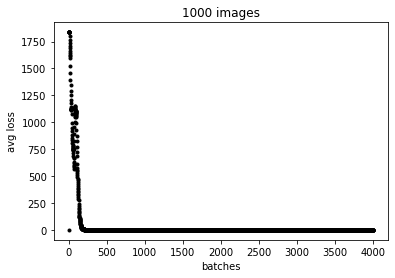

In [0]:
%cd /content/gdrive/'My Drive'/lowimages

import matplotlib.pyplot as plt
%matplotlib inline

batch = []
avgloss = []
with open('yolov3_bloodcells_train.log','r') as fobj:
  for line in fobj:
    if len(line.split()) != 14:
      continue
    elif 'avg loss' in line:
      batch.append(line.split()[0].split(':')[0])
      avgloss.append(line.split()[2])

batch = list(map(int, batch))
avgloss = list(map(float, avgloss))

print(batch)
print(avgloss)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(batch, avgloss, '.', color='black')
ax.set_title('1000 images')
ax.set_xlabel('batches')
ax.set_ylabel('avg loss')


Step 10. Check mAP.

/content/gdrive/My Drive/lowimages
['1000', '1100', '1200', '1300', '1400', '1500', '1600', '1700', '1800', '1900', '2000', '2100', '2200', '2300', '2400', '2500', '2600', '2700', '2800', '2900', '3000', '3100', '3200', '3300', '3400', '3500', '3600', '3700', '3800', '3900', '4000']
[0.604815, 0.754789, 0.795442, 0.703938, 0.881609, 0.915727, 0.908045, 0.941626, 0.797668, 0.937611, 0.87449, 0.949493, 0.955591, 0.959797, 0.958053, 0.971443, 0.973248, 0.952534, 0.928867, 0.870814, 0.977934, 0.967539, 0.98381, 0.98625, 0.986464, 0.985263, 0.984527, 0.985128, 0.984718, 0.985145, 0.984502]


Text(0, 0.5, 'mAP@0.5')

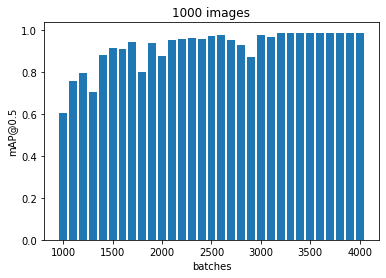

In [0]:
%cd /content/gdrive/'My Drive'/lowimages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

batch = list(range(1000, 4100, 100))
mAP = []
with open('yolov3_bloodcells_train.log','r') as fobj:
  for line in fobj:
    if "mean average precision (mAP@0.50) = " in line:
      mAP.append(line.split()[5].replace(',',''))

batch = list(map(str, batch))
mAP = list(map(float, mAP))

print(batch)
print(mAP)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(batch, mAP)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.set_title('1000 images')
ax.set_xlabel('batches')
ax.set_ylabel('mAP@0.5')

Step 11. Test the weights.

In [0]:
!rm -r /content/gdrive/'My Drive'/predictions
!rm -r /content/darknet/predictions

%cd /content/gdrive/'My Drive'
!mkdir predictions
!ln -s /content/gdrive/'My Drive'/predictions /content/darknet

%cd /content/darknet
import os
import glob
os.system
import PIL
import PIL.Image as Image

command = "./darknet detector test data/bloodcells/bloodcells.data cfg/yolov3_bloodcells.cfg /content/gdrive/'My Drive'/backup/yolov3_bloodcells_4000.weights -dont_show"
with open('data/bloodcells/test.txt','r') as f:
  for line in f:
    image_List = [[num for num in line.split()] for line in f]
    for images in image_List:
      name = images[0].split('/')[3].split('.')[0]
      commands = [command, images[0]]
      os.system(' '.join(commands))
      predicted_image = Image.open("predictions.jpg")
      output = 'predictions/' + name + '_prediction.jpg'
      predicted_image.save(output)


/content/gdrive/My Drive
/content/darknet


In [0]:
!cp -r /content/gdrive/'My Drive'/predictions /content/gdrive/'My Drive'/predictions_images

Step 12. Show the predicted images.

/content/drive/My Drive/predictions


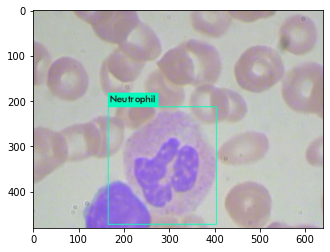

In [0]:
%cd /content/drive/'My Drive'/predictions
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

# Read image
im = imageio.imread("BloodImage_00313_NL_prediction.jpg")
plt.imshow(im)
